# Carvana competition

This competition is very exciting to me because I spent a good chunk of my time with CV algorithms this summer so it would be a great opportunity to put everything in practice and solidify my knowledge.

**Ideas**

* Can I train a model to predict the manufacturer?
* How can I utilize GAPs implicit localization properties.
* Can I identify and remove the letters in the background?
* Can I crop in parts, e.g. first localize then do it again?
* U-nets? Medical imaging, actually almost identical task.
* How does info about the car and all the metadata tell me anything about segmentation?
* Perhaps find color of car and change it to a different one to make segmentation easier?
* Image2Image Learning
* [Fishery competition winners approach](http://blog.kaggle.com/2017/07/07/the-nature-conservancy-fisheries-monitoring-competition-1st-place-winners-interview-team-towards-robust-optimal-learning-of-learning/) <-- VGG as feature extractor and then R-CNN
* [Mask R-CNN paper](https://arxiv.org/abs/1703.06870v2)


**Notes**
* Background seems to be always or almost always the same. Can I take advantage of that?
* Images are same size and **very** high resolution
* How do you deal with reflections and very bright spots?

In [20]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from sklearn.neighbors import DistanceMetric
from __future__ import division
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.misc import imresize

plt.style.use("fivethirtyeight")
%matplotlib inline

In [8]:
# Let's take a view of the dataset
data_dir = "data/train/"
mask_dir = "data/train_masks/"
all_images = os.listdir(data_dir)

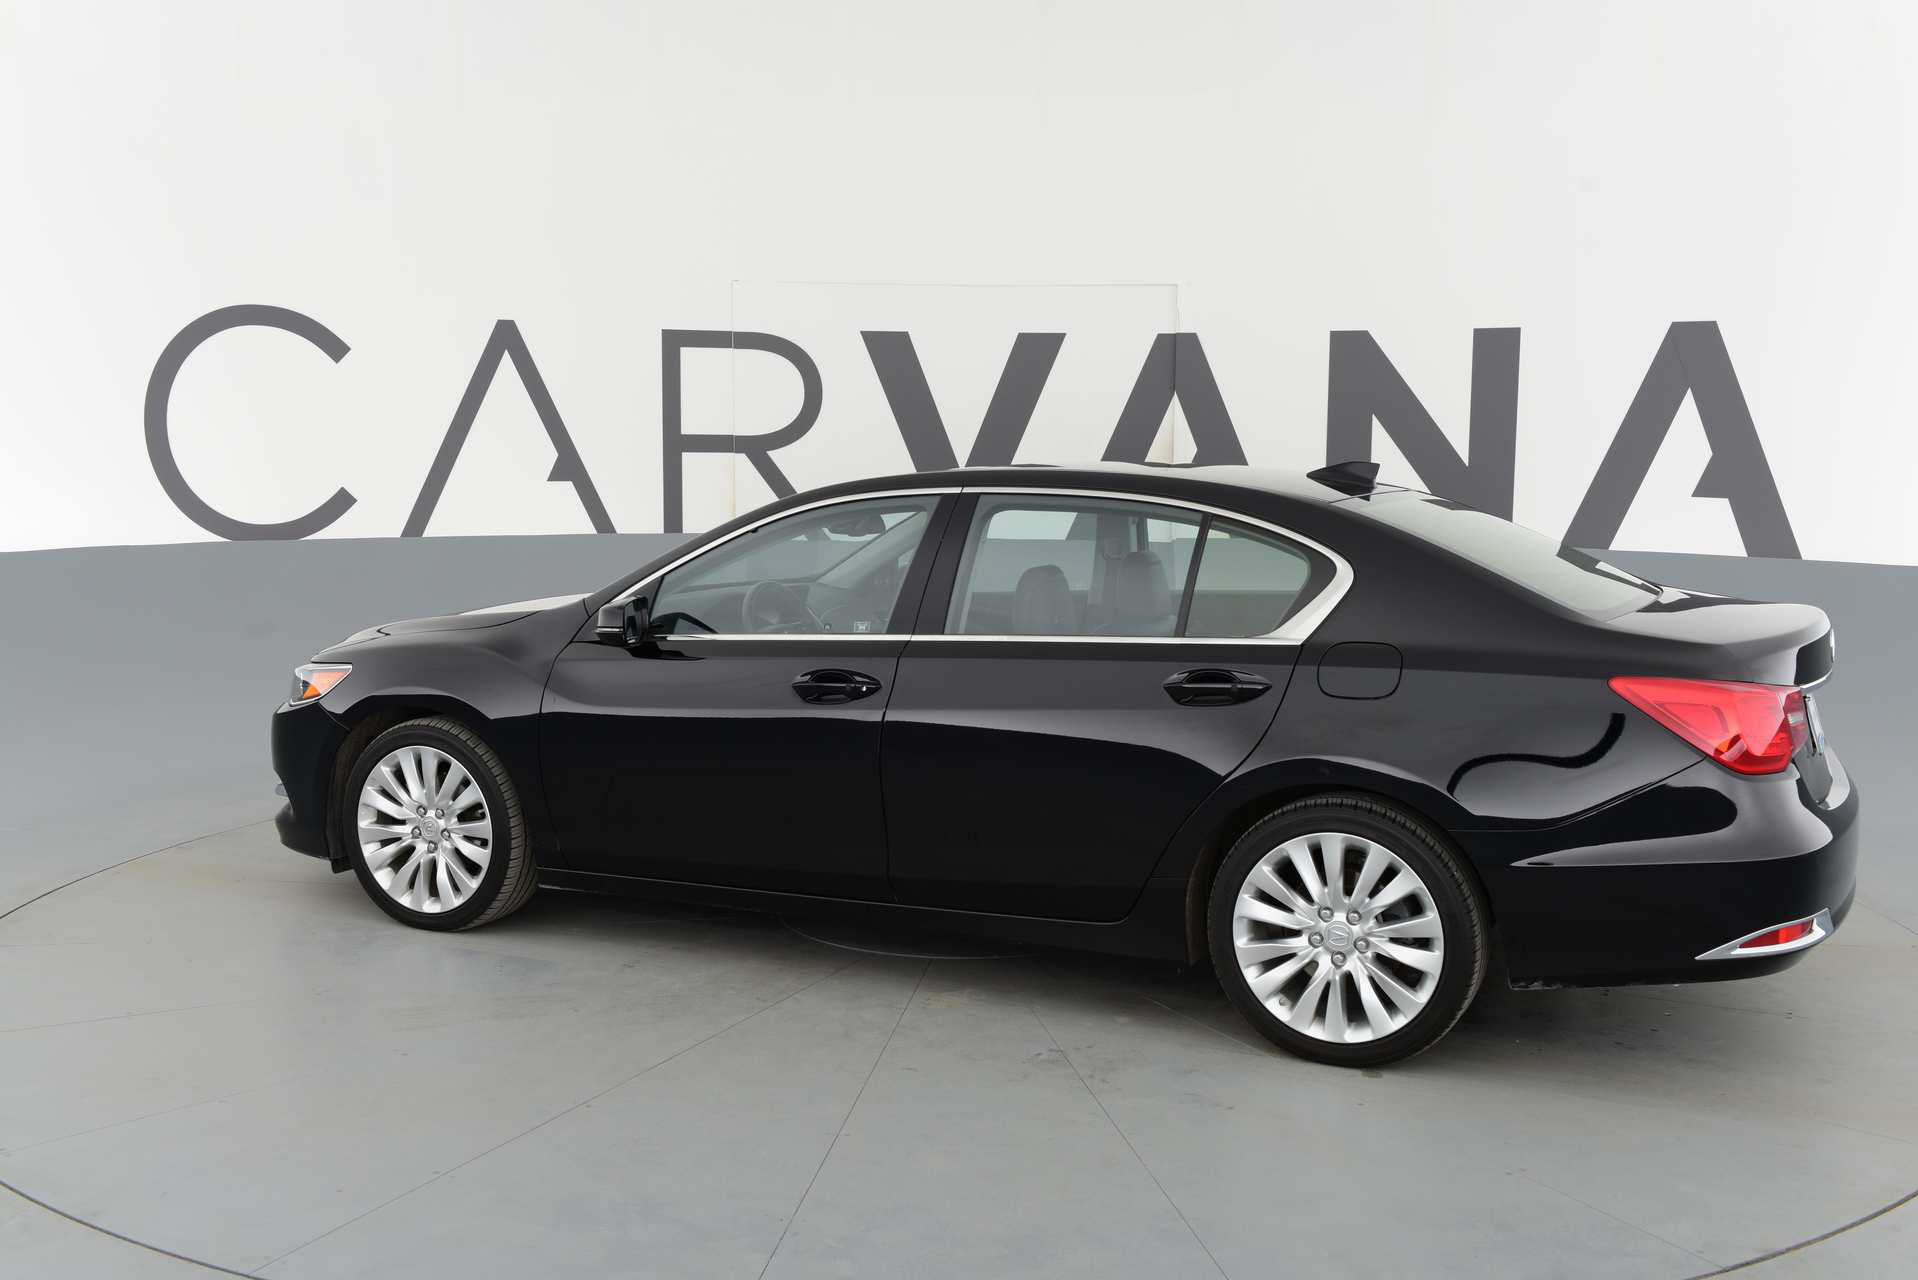

In [3]:
# example image
img = load_img(data_dir+all_images[5])
img_array = img_to_array(img)
img

In [4]:
img_array.shape # very high resolution, same for all images

(1280, 1918, 3)

In [5]:
# Let's make a function that samples some images from the datasets and presents them in a nice format
def vis_dataset(nrows=5, ncols=5, add_masks = False):
    f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20, 20))

    sampled_imgs = np.random.choice(all_images, nrows*ncols)
    sampled_imgs = [data_dir+i for i in sampled_imgs]

    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            image = load_img(sampled_imgs[counter])
            ax[i, j].imshow(img_to_array(image)/255)
            
            if add_masks:
                mask = load_img(mask_dir+sampled_imgs[counter].replace(data_dir, "").replace(".jpg", "")+"_mask.gif")
                ax[i, j].imshow(img_to_array(mask)/255, alpha=0.5)
            counter += 1

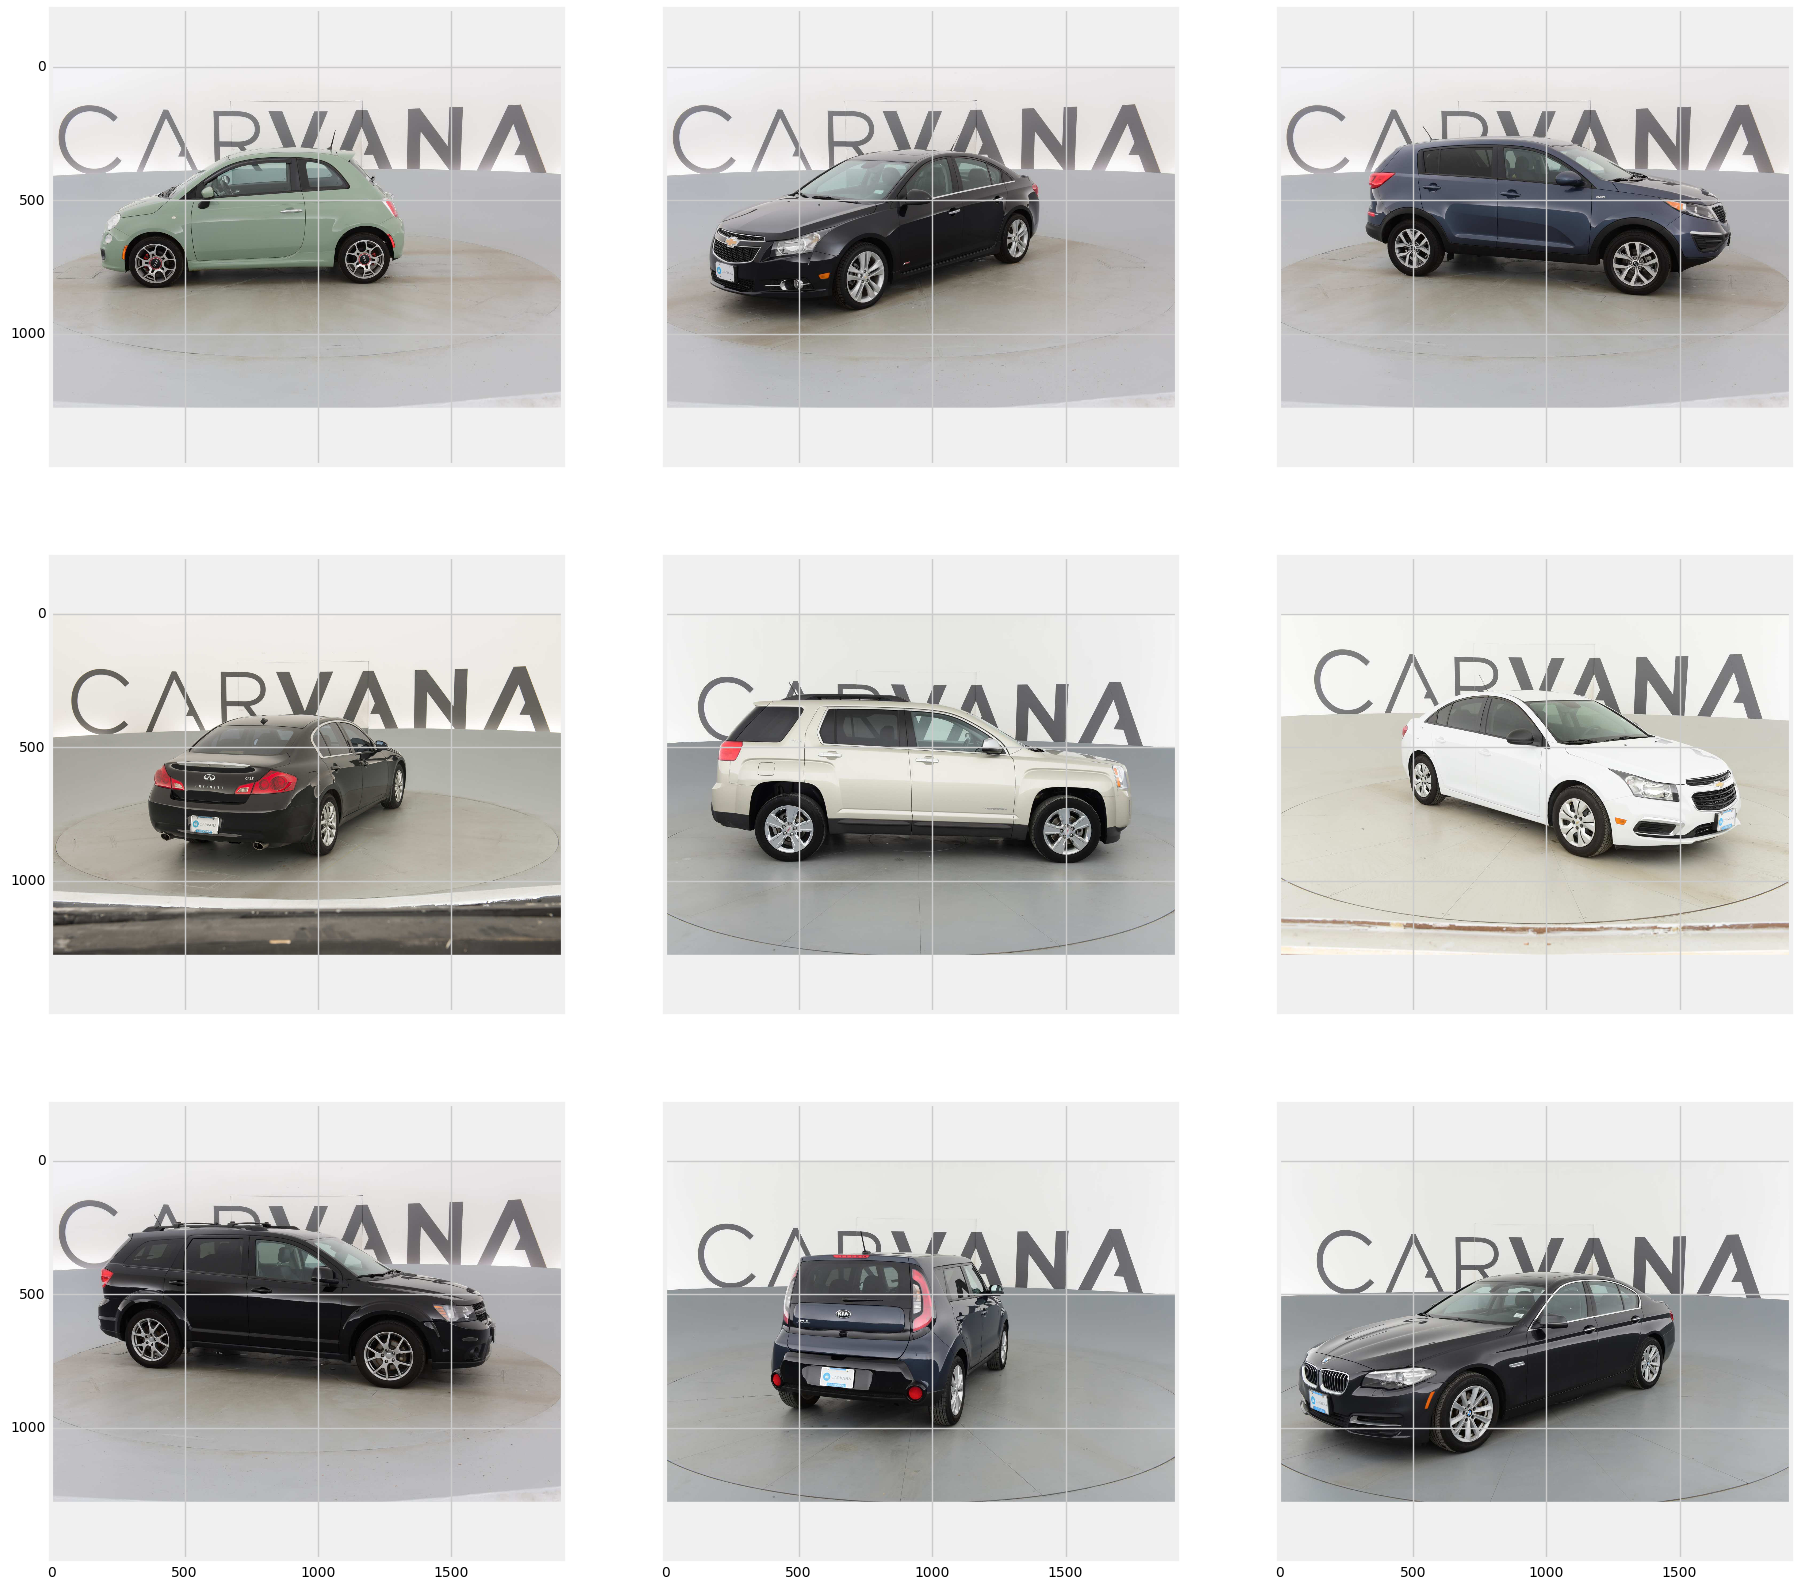

In [6]:
vis_dataset(nrows=3, ncols=3, add_masks=False)

OK! The other interesting thing about this dataset is the evaluation metric. "Dice". Essentially it has to do with the pixel overlap between the proposed and actual mask. Let's make sure we have an implementation of that for quick and nice evaluation.

In [7]:
# Let's check that edit distance stuff first!
def dice(u, v):
    """Given two vectors u and v, returns their dice distance"""
    numerator = 2*len(set(u).intersection(set(v)))
    denominator = len(set(u)) + len(set(v))
    return numerator/denominator

Try to make a convnet that predicts the manufacturer of the car?

In [22]:
metadata = pd.read_csv("data/metadata.csv")
maker = metadata[['id', 'make']].set_index("id")

My first attempt will be to try to make a network that predicts the manufacturer of the car. Since the images are too big to fit in memory, we will have to work with Keras's ```fit_generator``` function.

In [105]:
from sklearn.model_selection import train_test_split
train_images, validation_images = train_test_split(all_images, train_size=0.8)

In [174]:
# define a generator that returns one training sample
def train_gen():
    while True:
        ix = np.random.choice(np.arange(len(train_images)))
        img = img_to_array(load_img(data_dir+train_images[ix]))/255
        model = all_images[ix].split("_")[0]
        label = pd.get_dummies(maker).loc[model].values
        yield img.reshape(-1, 1280, 1918, 3), label.reshape(1, -1)

In [175]:
# Make a model to classify the manufacturer
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation="relu", input_shape=(1280, 1918, 3)))
model.add(MaxPool2D())
model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(256, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(512, kernel_size=(3,3), activation="relu"))
model.add(GlobalAveragePooling2D())
model.add(Dense(36, activation='softmax'))

In [176]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen(), steps_per_epoch=len(all_images), epochs=10, validation_steps=100)

In [1]:
# Use an existing network, downsample and then try the classification task with last layer be GAP
from keras.applications.vgg19 import VGG19

Using TensorFlow backend.


In [2]:
vgg19 = VGG19(include_top=False, weights='imagenet')

In [9]:
from sklearn.model_selection import train_test_split
train_images, validation_images = train_test_split(all_images, train_size=0.8)

In [164]:
# define a generator that returns one training sample
def train_gen(batch_size=1):
    while True:
        ix = np.random.choice(np.arange(len(train_images)), batch_size)
        imgs = []
        labels = []
        for i in ix:
            img = img_to_array(load_img(data_dir+train_images[i]))/255
            imgs.append(img)
            model = train_images[i].split("_")[0]
            label = pd.get_dummies(maker).loc[model].values
            labels.append(label)
        imgs= np.array(imgs)
        labels= np.array(labels)
        yield imgs.reshape(-1, 1280, 1918, 3), imgs.reshape(-1, 1280, 1918, 3)

In [165]:
from keras.layers import merge, Convolution2D, Input, Conv2DTranspose, UpSampling2D

In [166]:
# Make a deconvolutional Layer
model = Sequential()
# Conv block 1
model.add(Conv2D(32, kernel_size=(7,7), activation='relu', input_shape=(1280, 1918, 3)))
model.add(Conv2D(32, kernel_size=(7,7), activation='relu'))
model.add(Conv2D(32, kernel_size=(7,7), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))

# Conv block 2
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))

# Conv block 3
model.add(Conv2D(128, kernel_size=(3,3), activation='tanh'))
model.add(Conv2D(128, kernel_size=(3,3), activation='tanh'))
model.add(Conv2D(128, kernel_size=(3,3), activation='tanh'))
model.add(MaxPool2D(pool_size=(3,3)))
          
# Latent representation
model.add(Conv2D(256, kernel_size=(2,2), activation='tanh'))
model.add(Conv2DTranspose(256, kernel_size=(2,2), activation='tanh'))

# Deconvolution Block 1
model.add(UpSampling2D(size=(3,3)))
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='tanh'))
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='tanh'))
model.add(Conv2DTranspose(128, kernel_size=(3,3), activation='tanh'))


# Deconvolution Block 2
model.add(UpSampling2D(size=(3,3)))
model.add(Conv2DTranspose(64, kernel_size=(5,5), activation='relu'))
model.add(Conv2DTranspose(64, kernel_size=(5,5), activation='relu'))
model.add(Conv2DTranspose(64, kernel_size=(5,5), activation='relu'))


# Deconvolution Block 3
model.add(UpSampling2D(size=(3,3)))
model.add(Conv2DTranspose(32, kernel_size=(7,7), activation='relu'))
model.add(Conv2DTranspose(32, kernel_size=(7,7), activation='relu'))
model.add(Conv2DTranspose(32, kernel_size=(7,7), activation='relu'))

model.add(Conv2DTranspose(3, kernel_size=(12,2)))

In [1]:
def  dice(y_true, y_pred):
    # Symbolically compute the intersection
    y_int = y_true*y_pred
    # Technically this is the negative of the Sorensen-Dice index. This is done for
    # minimization purposes
    return (2*K.sum(y_int) / (KTF.sum(y_true) + KTF.sum(y_pred)))

In [167]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_gen(1), steps_per_epoch=len(all_images), epochs=10, validation_steps=100)

Epoch 1/10
